## Q1 a
[1 point] Compute magnitude of gradients of an image

In [1]:
import numpy as np
from skimage import io, color, filters
import matplotlib.pyplot as plt
from scipy.ndimage import correlate as corr

In [2]:
Sobel_x = np.array([[-1, 0, 1]])  # This is actually a horizontal edge detector component
Sobel_y = np.array([[1, 2, 1]])   # This is a vertical weighting component
Sobel_kernel_x = Sobel_y.T @ Sobel_x  # This is for vertical edges (changes in y-direction)
Sobel_kernel_y = Sobel_x.T @ Sobel_y  # This is for horizontal edges (changes in x-direction)

In [3]:
def magnitude(image):
    # Ensure the image is in grayscale
    if len(image.shape) == 3:
        image = color.rgb2gray(image)
    # Apply the Sobel filter for both horizontal and vertical directions
    derivative_horizontal = corr(image, Sobel_kernel_y)  # For horizontal edges
    derivative_vertical = corr(image, Sobel_kernel_x)  # For vertical edges
    # Compute the magnitude of gradients
    magnitude = np.sqrt(derivative_horizontal ** 2 + derivative_vertical ** 2)
    return magnitude

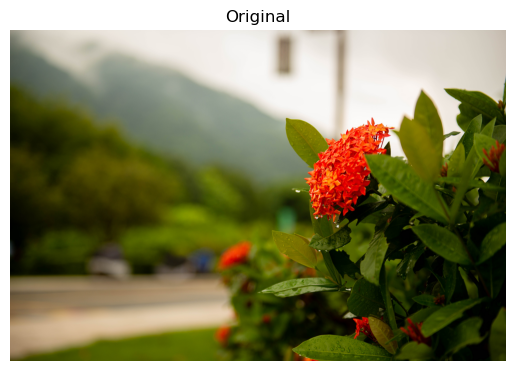

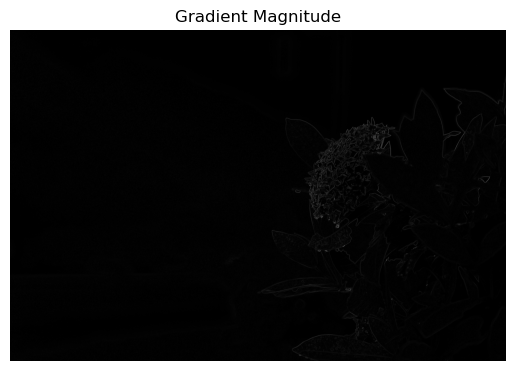

In [4]:
image_path = 'roadFlower.jpg'  # Replace with your image path
image = io.imread(image_path)

plt.imshow(image, cmap='gray')
plt.title('Original')
plt.axis('off')  # Hide axes ticks
plt.show()

gradient_magnitude = magnitude(image)

# Display the result
plt.imshow(gradient_magnitude, cmap='gray')
plt.title('Gradient Magnitude')
plt.axis('off')  # Hide axes ticks
plt.show()

## Q1 b
[4 points] Find the connected path of pixels that has the smallest sum of gradients. A
path is valid if it is connected (the neighboring points in the path are also neighboring
pixels in the image), it starts in the first row of the image and in each step continues one
row down. It finishes in the last row of the image.

In [5]:
def compute_cumulative_energy(gradient_image):
    rows, cols = gradient_image.shape
    M = np.zeros_like(gradient_image, dtype=np.float64)
    M[0, :] = gradient_image[0, :]
    backtrack = np.zeros_like(gradient_image, dtype=np.int_)

    for i in range(1, rows):
        for j in range(cols):
            # Handle the left edge of the image
            if j == 0:
                # Find the min gradient from j directly above and j diagonally right above
                idx = np.argmin(M[i-1, j:j+1])
                # Recorde which location above is the smallest eg [0 + j]: top; [1 + j]: top right.
                backtrack[i, j] = idx + j
                # Record 2 magnitude
                min_magnitude = M[i-1, idx]   
            else:
                # Find the min gradient from j directly above, j diagonally left above and j diagonally right above
                idx = np.argmin(M[i-1, max(j-1, 0):min(j+2, cols)])
                # Recorde which location above is the smallest eg [0 + j]: top left; [1 + j]: top; [2 + j]: top right.
                backtrack[i, j] = idx + j - 1
                 # Record 3 magnitude
                min_magnitude = M[i-1, idx + j - 1]
            
            M[i, j] = gradient_image[i, j] + min_magnitude
    return M, backtrack

In [6]:
def find_optimal_seam(M, backtrack):
    rows, cols = M.shape
    seam = np.zeros(rows, dtype=np.int_)

    # Start with the minimum magnitude pixel in the last row
    seam[rows-1] = np.argmin(M[-1])
    for i in range(rows-2, -1, -1):
        seam[i] = backtrack[i+1, seam[i+1]]

    return seam

In [7]:
M, backtrack = compute_cumulative_energy(gradient_magnitude)
optimal_seam = find_optimal_seam(M, backtrack)

In [8]:
def draw_wide_seam_on_image(image, seam, width=10, color=[255, 0, 0]):
    # Make a copy of the image to avoid modifying the original
    image_with_wide_seam = np.copy(image)
    
    rows, cols = image.shape[:2]
    
    # Iterate over each row in the image
    for row, seam_col in enumerate(seam):
        # Calculate the start and end column indices for the seam, constrained by image boundaries
        start_col = max(seam_col - width, 0)
        end_col = min(seam_col + width, cols - 1)
        
        # Apply the specified color to the wide seam area
        if len(image.shape) == 3:  # Color image
            image_with_wide_seam[row, start_col:end_col+1, :] = color
        else:  # Grayscale image
            image_with_wide_seam[row, start_col:end_col+1] = 255  # Set to white for visibility
    
    return image_with_wide_seam


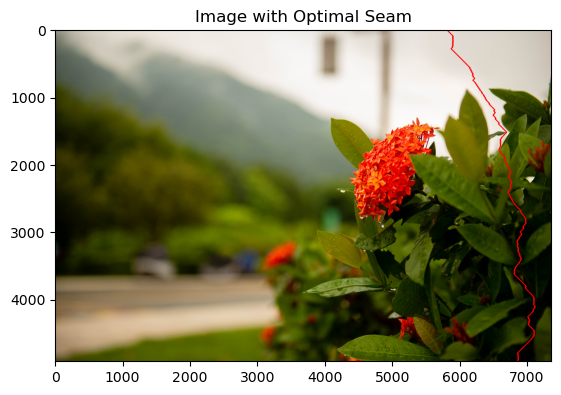

In [9]:
image_path = 'roadFlower.jpg'
image = io.imread(image_path)
seam_image = draw_wide_seam_on_image(image, optimal_seam)
# Display the result
plt.imshow(seam_image)
plt.title('Image with Optimal Seam')
plt.show()

## Q1 c
[1 point] Remove the pixels in the path from the image. This gives you a new image with
one column less.

In [10]:
def remove_seam(image, seam):
    rows, cols = image.shape[:2]
    # Determine if the image is grayscale or color based on the number of dimensions
    channel_count = image.shape[2] if len(image.shape) == 3 else 1
    # Create a new image array with one less column
    if channel_count == 1:  # Grayscale image
        new_image = np.zeros((rows, cols-1), dtype=image.dtype)
    else:  # Color image
        new_image = np.zeros((rows, cols-1, channel_count), dtype=image.dtype)
    
    # Iterate over each row in the image
    for row in range(rows):
        col = seam[row]
        # Copy the part of the row before the seam
        new_image[row, :col] = image[row, :col]
        # Copy the part of the row after the seam
        new_image[row, col:] = image[row, col+1:]
    
    return new_image

In [11]:
removed = remove_seam(image, optimal_seam)
print(image.shape)
print(removed.shape)

(4912, 7360, 3)
(4912, 7359, 3)


Q1 d
[1 point] Remove a few paths with the lowest sum of gradients. Create a few examples
and include them in your document.

In [12]:
def remove_seams(image, nums = 10):
    for _ in range(nums):
        gradient_image = magnitude(image)
        M, backtrack = compute_cumulative_energy(gradient_image)
        opt = find_optimal_seam(M, backtrack)
        removed_image = remove_seam(image, opt)
        image = removed_image
    return image


(4912, 7360, 3)


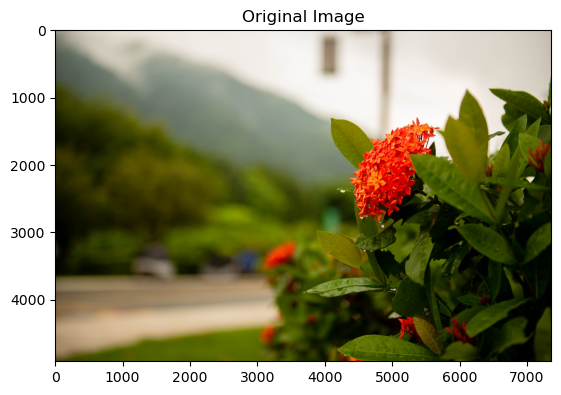

(4912, 7350, 3)


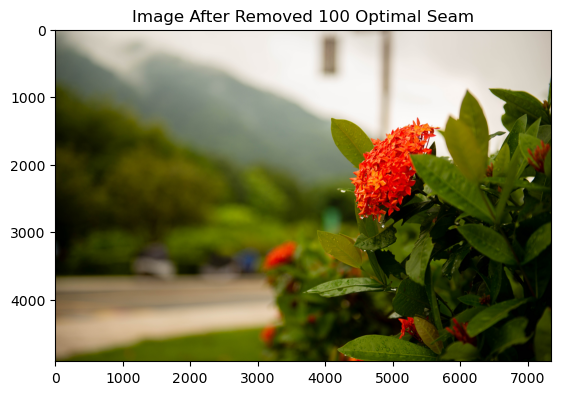

In [13]:
image_path = 'roadFlower.jpg'
image = io.imread(image_path)
final_image = remove_seams(image)
# Display the result
print(image.shape)
plt.imshow(image)
plt.title('Original Image')
plt.show()
print(final_image.shape)
plt.imshow(final_image)
plt.title('Image After Removed 10 Optimal Seam')
plt.show()